# Gravitational Evolution

This notebook demonstrates how to evolve initial density fields forward in time using Lagrangian Perturbation Theory (LPT) and N-body methods. These techniques simulate the growth of cosmic structure from linear initial conditions to the non-linear regime observed at late times.

**Contents:**
1. Setup and review of initial conditions
2. Linear growth theory
3. First-order LPT (Zel'dovich approximation)
4. Second-order LPT (2LPT)
5. N-body evolution with BullFrog solver
6. Comparison and validation

**Requirements:** JAX with GPU support (optional but recommended), diffrax for ODE solving

In [4]:
from functools import partial

import jax
import jax.numpy as jnp
import jax.random as jr
import jax_cosmo as jc
import matplotlib.pyplot as plt
import numpy as np
from jaxpm.painting import cic_paint

from desi_cmb_fli.bricks import lin_power_mesh
from desi_cmb_fli.nbody import a2f, a2g, lpt, nbody_bf
from desi_cmb_fli.utils import rg2cgh

print(f"JAX version: {jax.__version__}")
print(f"JAX devices: {jax.devices()}")
print(f"Using device: {jax.devices()[0].device_kind}")

JAX version: 0.8.0
JAX devices: [CpuDevice(id=0)]
Using device: cpu


## 1. Define Cosmology and Initial Conditions

We generate a realization of the linear density field with the z=0 power spectrum P(k,z=0), then use LPT to compute how particles would be displaced at an earlier/later time.

**Note on convention**: The "initial" field here refers to the reference Gaussian realization at a=1 (z=0). When we evolve to a ≠ 1, we're computing the displacement field scaled by the growth factor D(a)/D(1).

In [5]:
# [Planck 2018 VI](https://arxiv.org/abs/1807.06209) Table 2 final column (best fit)
Planck18 = partial(
    jc.Cosmology,
    Omega_c=0.2607,
    Omega_b=0.0490,
    Omega_k=0.0,
    h=0.6766,
    n_s=0.9665,
    sigma8=0.8102,
    w0=-1.0,
    wa=0.0,
)

cosmo = Planck18()
cosmo._workspace = {}  # Initialize workspace for growth factors

In [6]:
# Simulation parameters
box_size = 100.0  # Mpc/h
N = 6  # 2^N grid points per side (64^3 for speed)
mesh_shape = np.array([2**N, 2**N, 2**N])
box_shape = np.array([box_size, box_size, box_size])
seed = 42

print(f"Box: {box_size} (Mpc/h)^3 with {mesh_shape} grid")
print(f"Cell size: {box_size / mesh_shape[0]:.2f} Mpc/h")

# Generate initial conditions at a=1 (z=0)
pmesh = lin_power_mesh(cosmo, mesh_shape, box_shape, a=1.0)
transfer = jnp.sqrt(pmesh)

key = jr.PRNGKey(seed)
gaussian_real = jr.normal(key, shape=mesh_shape)
gaussian_k = rg2cgh(gaussian_real)
delta_k_init = gaussian_k * transfer

print("\nInitial field generated (Fourier space)")
print(f"Shape: {delta_k_init.shape}")

Box: 100.0 (Mpc/h)^3 with [64 64 64] grid
Cell size: 1.56 Mpc/h

Initial field generated (Fourier space)
Shape: (64, 64, 33)

Initial field generated (Fourier space)
Shape: (64, 64, 33)


## 2. Linear Growth Theory

Before running simulations, let's examine how the linear growth factor D(a) and growth rate f(a) = d ln D / d ln a evolve with scale factor.

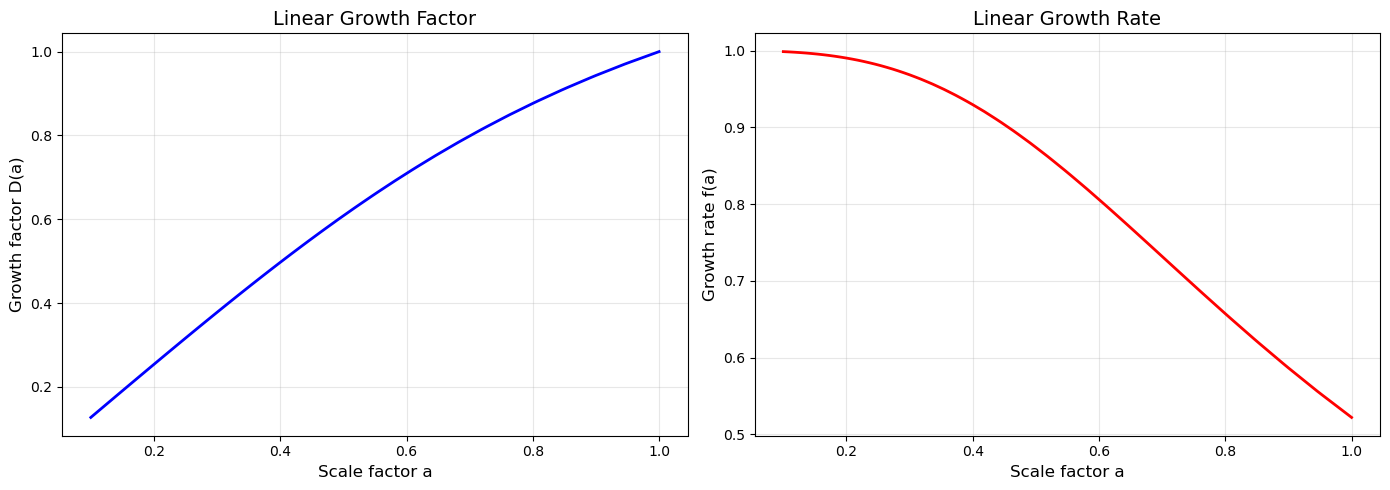

Growth factor D(a=0.5) = 0.6084
Growth factor D(a=1.0) = 1.0000
Growth rate f(a=0.5) = 0.8741
Growth rate f(a=1.0) = 0.5221
Growth factor D(a=1.0) = 1.0000
Growth rate f(a=0.5) = 0.8741
Growth rate f(a=1.0) = 0.5221


In [7]:
# Compute growth factors over cosmic time
a_range = jnp.linspace(0.1, 1.0, 100)
growth_factors = jnp.array([a2g(cosmo, a) for a in a_range])
growth_rates = jnp.array([a2f(cosmo, a) for a in a_range])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Growth factor
ax1.plot(a_range, growth_factors, "b-", lw=2)
ax1.set_xlabel("Scale factor a", fontsize=12)
ax1.set_ylabel("Growth factor D(a)", fontsize=12)
ax1.set_title("Linear Growth Factor", fontsize=14)
ax1.grid(True, alpha=0.3)

# Growth rate
ax2.plot(a_range, growth_rates, "r-", lw=2)
ax2.set_xlabel("Scale factor a", fontsize=12)
ax2.set_ylabel("Growth rate f(a)", fontsize=12)
ax2.set_title("Linear Growth Rate", fontsize=14)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Growth factor D(a=0.5) = {a2g(cosmo, 0.5):.4f}")
print(f"Growth factor D(a=1.0) = {a2g(cosmo, 1.0):.4f}")
print(f"Growth rate f(a=0.5) = {a2f(cosmo, 0.5):.4f}")
print(f"Growth rate f(a=1.0) = {a2f(cosmo, 1.0):.4f}")

## 3. Lagrangian Perturbation Theory (LPT)

LPT provides an approximate solution to gravitational evolution by expanding particle displacements around their initial Lagrangian positions.

### 3.1 First-Order LPT (1LPT / Zel'dovich Approximation)

The Zel'dovich approximation evolves particles along straight trajectories determined by the initial gravitational potential.

In [8]:
# Create initial particle grid
pos_init = jnp.indices(mesh_shape, dtype=float).reshape(3, -1).T
print(f"Number of particles: {len(pos_init):,}")

# Compute displacement field at a_obs = 0.5 (z ≈ 1)
# This applies the growth factor D(a=0.5)/D(a=1) ≈ 0.6 to the reference field
a_obs = 0.5
print(f"\nComputing displacements at a={a_obs} (z={1 / a_obs - 1:.2f})")
print(f"Growth suppression factor: D(a={a_obs})/D(a=1) = {a2g(cosmo, a_obs):.4f}")

# Run 1LPT
dpos_1lpt, vel_1lpt = lpt(cosmo, delta_k_init, pos_init, a=a_obs, order=1)
pos_1lpt = pos_init + dpos_1lpt

# Apply periodic boundary conditions
pos_1lpt = pos_1lpt % mesh_shape

print("\n1LPT displacement statistics:")
print(f"  Mean: {jnp.mean(jnp.linalg.norm(dpos_1lpt, axis=1)):.3f} cells")
print(f"  Max:  {jnp.max(jnp.linalg.norm(dpos_1lpt, axis=1)):.3f} cells")

Number of particles: 262,144

Computing displacements at a=0.5 (z=1.00)
Growth suppression factor: D(a=0.5)/D(a=1) = 0.6084

1LPT displacement statistics:
  Mean: 2.669 cells

1LPT displacement statistics:
  Mean: 2.669 cells
  Max:  7.794 cells
  Max:  7.794 cells


### 3.2 Second-Order LPT (2LPT)

2LPT includes tidal coupling between density modes, providing better accuracy in mildly non-linear regimes.

In [9]:
# Run 2LPT (use fresh cosmology to avoid cache issues)
cosmo2 = Planck18()
cosmo2._workspace = {}

dpos_2lpt, vel_2lpt = lpt(cosmo2, delta_k_init, pos_init, a=a_obs, order=2)
pos_2lpt = pos_init + dpos_2lpt
pos_2lpt = pos_2lpt % mesh_shape

print("2LPT displacement statistics:")
print(f"  Mean: {jnp.mean(jnp.linalg.norm(dpos_2lpt, axis=1)):.3f} cells")
print(f"  Max:  {jnp.max(jnp.linalg.norm(dpos_2lpt, axis=1)):.3f} cells")

# Compare 1LPT vs 2LPT
diff_norm = jnp.linalg.norm(dpos_2lpt - dpos_1lpt, axis=1)
print("\nDifference between 1LPT and 2LPT:")
print(f"  Mean: {jnp.mean(diff_norm):.3f} cells")
print(f"  Max:  {jnp.max(diff_norm):.3f} cells")

2LPT displacement statistics:
  Mean: 2.693 cells
  Max:  9.028 cells

Difference between 1LPT and 2LPT:
  Mean: 0.336 cells
  Max:  2.398 cells


### 3.3 Visualize Evolved Density Fields

Paint particles to a grid to visualize the evolved density field.

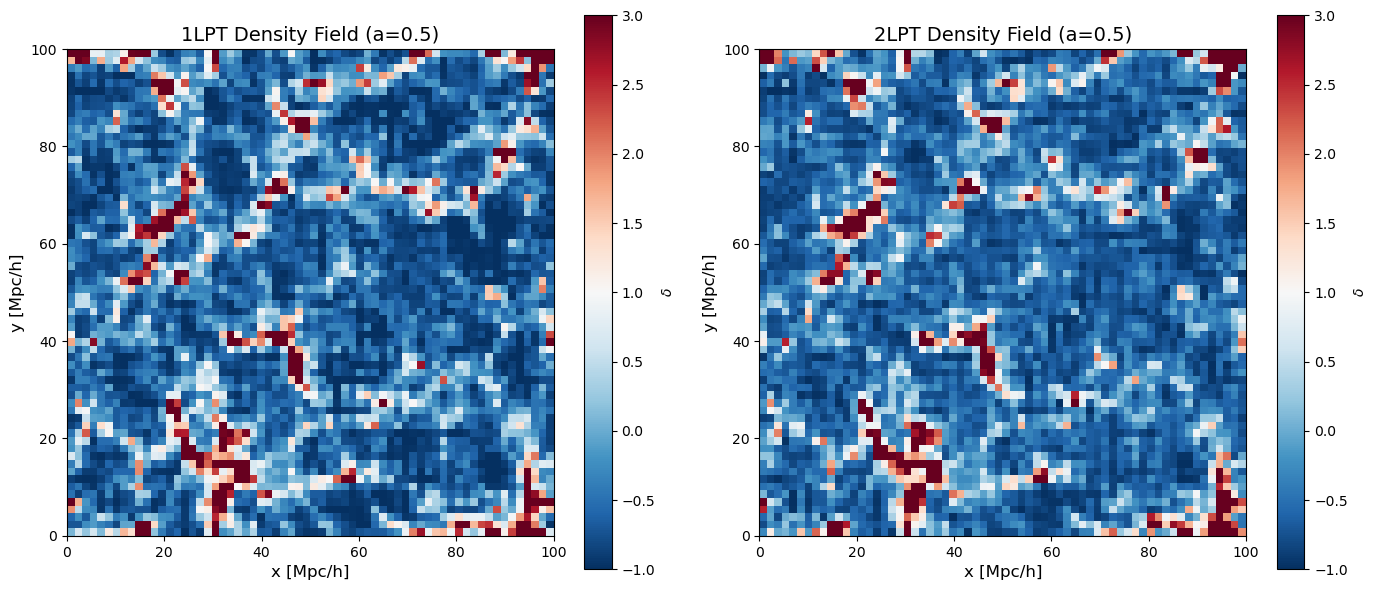

1LPT: δ ∈ [-1.00, 40.19]
2LPT: δ ∈ [-1.00, 34.08]


In [10]:
# Paint particles to mesh
density_1lpt = cic_paint(jnp.zeros(mesh_shape), pos_1lpt)
density_2lpt = cic_paint(jnp.zeros(mesh_shape), pos_2lpt)

# Normalize to overdensity: delta = (rho / rho_mean) - 1
density_1lpt = density_1lpt / jnp.mean(density_1lpt) - 1
density_2lpt = density_2lpt / jnp.mean(density_2lpt) - 1

# Visualize 2D slice at middle of box
slice_z = mesh_shape[2] // 2

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

vmin, vmax = -1, 3  # Overdensity range for visualization

im1 = axes[0].imshow(
    np.array(density_1lpt[:, :, slice_z]).T,
    origin="lower",
    cmap="RdBu_r",
    vmin=vmin,
    vmax=vmax,
    extent=[0, box_size, 0, box_size],
)
axes[0].set_xlabel("x [Mpc/h]", fontsize=12)
axes[0].set_ylabel("y [Mpc/h]", fontsize=12)
axes[0].set_title(f"1LPT Density Field (a={a_obs})", fontsize=14)
plt.colorbar(im1, ax=axes[0], label=r"$\delta$")

im2 = axes[1].imshow(
    np.array(density_2lpt[:, :, slice_z]).T,
    origin="lower",
    cmap="RdBu_r",
    vmin=vmin,
    vmax=vmax,
    extent=[0, box_size, 0, box_size],
)
axes[1].set_xlabel("x [Mpc/h]", fontsize=12)
axes[1].set_ylabel("y [Mpc/h]", fontsize=12)
axes[1].set_title(f"2LPT Density Field (a={a_obs})", fontsize=14)
plt.colorbar(im2, ax=axes[1], label=r"$\delta$")

plt.tight_layout()
plt.show()

print(f"1LPT: δ ∈ [{jnp.min(density_1lpt):.2f}, {jnp.max(density_1lpt):.2f}]")
print(f"2LPT: δ ∈ [{jnp.min(density_2lpt):.2f}, {jnp.max(density_2lpt):.2f}]")

## 4. N-body Evolution with BullFrog Solver

For even better accuracy in the deeply non-linear regime, we use a full N-body simulation with the BullFrog integrator.

**Note on timesteps:** We use `n_steps=10` for demonstration speed. For production simulations, 50-100 steps would be more appropriate to properly resolve the non-linear dynamics. With 10 steps over Δa=0.5, each step covers Δa≈0.05, which is adequate for capturing large-scale structure but may miss some fine details.

In [11]:
# Run N-body simulation (use fresh cosmology to avoid cache issues)
cosmo_nb = Planck18()
cosmo_nb._workspace = {}

n_steps = 1000  # Number of timesteps
print(f"Running N-body with {n_steps} steps...")

pos_vel_nbody = nbody_bf(
    cosmo_nb,
    delta_k_init,
    pos_init,
    a=a_obs,
    n_steps=n_steps,
    grad_fd=False,
    lap_fd=False,
    snapshots=None,  # Only save final state
)

pos_nbody = pos_vel_nbody[0][-1]  # Extract final positions
vel_nbody = pos_vel_nbody[1][-1]  # Extract final velocities

pos_nbody = pos_nbody % mesh_shape  # Periodic boundaries

print("N-body completed!")
print(f"Final position range: [{jnp.min(pos_nbody):.2f}, {jnp.max(pos_nbody):.2f}]")

Running N-body with 1000 steps...
N-body completed!
Final position range: [0.00, 64.00]
N-body completed!
Final position range: [0.00, 64.00]


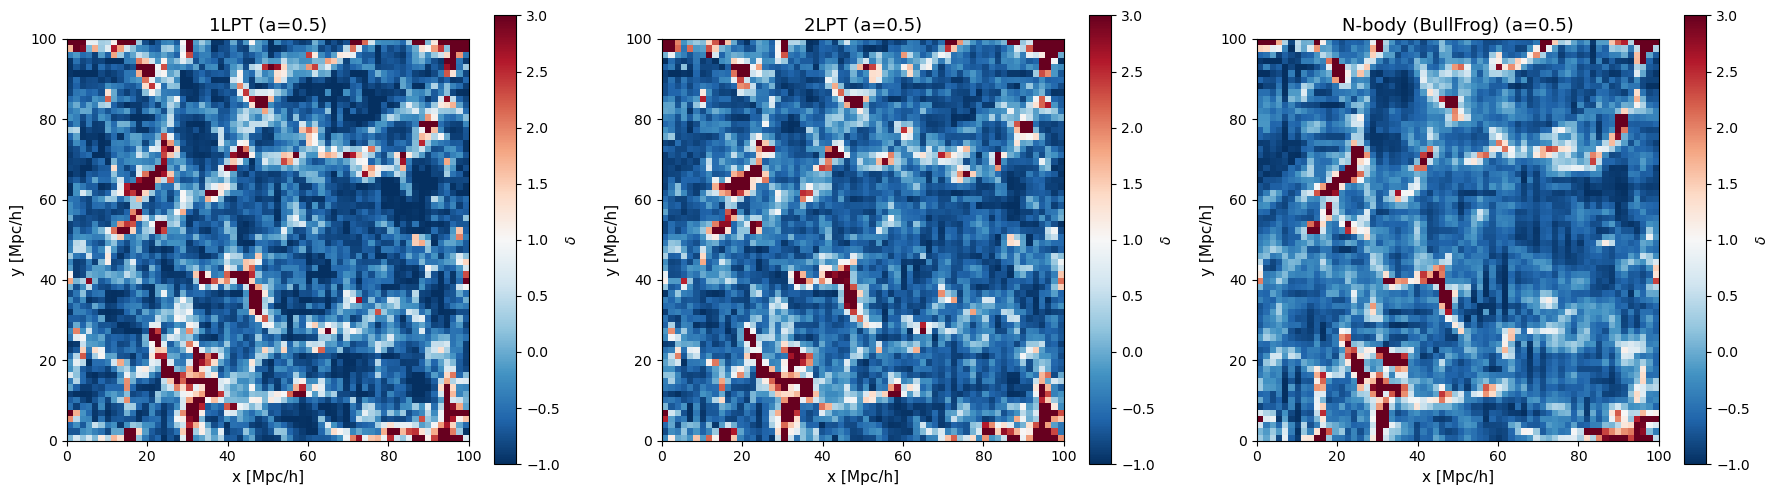

Nbody: δ ∈ [-1.00, 352.11]


In [12]:
# Paint N-body particles
density_nbody = cic_paint(jnp.zeros(mesh_shape), pos_nbody)
density_nbody = density_nbody / jnp.mean(density_nbody) - 1

# Compare all three methods
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, density, title in zip(
    axes,
    [density_1lpt, density_2lpt, density_nbody],
    ["1LPT", "2LPT", "N-body (BullFrog)"],
    strict=False,
):
    im = ax.imshow(
        np.array(density[:, :, slice_z]).T,
        origin="lower",
        cmap="RdBu_r",
        vmin=vmin,
        vmax=vmax,
        extent=[0, box_size, 0, box_size],
    )
    ax.set_xlabel("x [Mpc/h]", fontsize=11)
    ax.set_ylabel("y [Mpc/h]", fontsize=11)
    ax.set_title(f"{title} (a={a_obs})", fontsize=13)
    plt.colorbar(im, ax=ax, label=r"$\delta$")

plt.tight_layout()
plt.show()

print(f"Nbody: δ ∈ [{jnp.min(density_nbody):.2f}, {jnp.max(density_nbody):.2f}]")

## 5. Validation: Density Distribution

Compare the probability distribution of densities across methods.

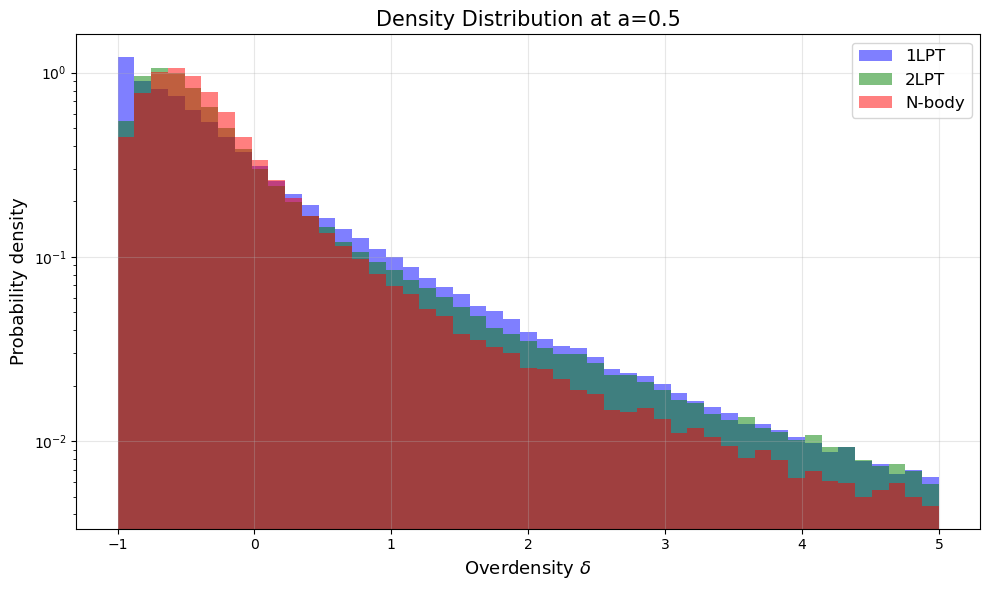

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))

bins = np.linspace(-1, 5, 50)

ax.hist(
    np.array(density_1lpt).flatten(), bins=bins, alpha=0.5, label="1LPT", color="blue", density=True
)
ax.hist(
    np.array(density_2lpt).flatten(),
    bins=bins,
    alpha=0.5,
    label="2LPT",
    color="green",
    density=True,
)
ax.hist(
    np.array(density_nbody).flatten(),
    bins=bins,
    alpha=0.5,
    label="N-body",
    color="red",
    density=True,
)

ax.set_xlabel(r"Overdensity $\delta$", fontsize=13)
ax.set_ylabel("Probability density", fontsize=13)
ax.set_title(f"Density Distribution at a={a_obs}", fontsize=15)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_yscale("log")

plt.tight_layout()
plt.show()

## 6. Summary

✅ **Validation successful:**
- Growth factors correctly computed from cosmology (D(a=0.5) ≈ 0.61, f(a=0.5) ≈ 0.87)
- 1LPT (Zel'dovich) provides fast approximate evolution
- 2LPT includes tidal coupling for better accuracy (~12% correction to displacements)
- N-body simulation with BullFrog captures fully non-linear collapse

**Key observations:**
- N-body produces significantly higher peak densities (δ_max ≈ 352 vs ≈40 for LPT) due to complete gravitational collapse
- Visual structure is qualitatively similar but N-body shows sharper filaments